In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import cv2

folder_path = "20230530_segm_black_mouse_mnSLA_red_and_black_back"

seed_value = 52
torch.manual_seed(seed_value)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [102]:
def augmentation():
    count_image = 400
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    image_files = os.listdir(path_images)
    selected_files_for_vertical = random.sample(image_files, count_image)

    for filename in selected_files_for_vertical:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_images, f'revert_vertical_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        output_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    # selected_files_for_horizontal = []
    count_image = 1
    selected_files_for_horizontal = random.sample(image_files, count_image)

    for filename in selected_files_for_horizontal:
        image_path = os.path.join(path_images, filename)
        image = Image.open(image_path)
        rotated_image = image.transpose(Image.FLIP_TOP_BOTTOM)
        output_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        rotated_image.save(output_path)
        image.close()

        mask_path = os.path.join(path_masks, filename)
        mask = Image.open(mask_path)
        rotated_mask = mask.transpose(Image.FLIP_TOP_BOTTOM)
        output_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        rotated_mask.save(output_path)
        mask.close()

    return selected_files_for_vertical, selected_files_for_horizontal


def delete_generated_images(data_vert, data_hor):
    path_images = "20230530_segm_black_mouse_mnSLA_red_and_black_back/images"
    path_masks = "20230530_segm_black_mouse_mnSLA_red_and_black_back/masks"

    for filename in data_vert:
        output_image_path = os.path.join(path_images, f'revert_vertical_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_vertical_{filename}')
        os.remove(output_mask_path)

    for filename in data_hor:
        output_image_path = os.path.join(path_images, f'revert_horizontal_{filename}')
        os.remove(output_image_path)

        output_mask_path = os.path.join(path_masks, f'revert_horizontal_{filename}')
        os.remove(output_mask_path)

In [103]:
def make_csv_files(folder_path, folder):
    images_folder = folder_path + "/" + folder + "images"
    masks_folder = folder_path + "/" + folder + "masks"

    images_files = os.listdir(images_folder)
    masks_files = os.listdir(masks_folder)

    image_paths = [os.path.join(folder + "images", file) for file in images_files]
    mask_paths = [os.path.join(folder + "masks", file) for file in masks_files]

    data = {'orig_image': image_paths, 'mask_image': mask_paths}
    df = pd.DataFrame(data)

    csv_file_path = "train_data.csv" if folder == "" else "test_data.csv"

    df.to_csv(csv_file_path, index=False)

In [104]:
data_vertical, data_horizontal = augmentation()
make_csv_files(folder_path, "")
make_csv_files(folder_path, "test_")

In [105]:
train_df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [106]:
def draw(orig_image, orig_masks, mask_image, intersec_mask):
    fig, axes = plt.subplots(1, 4)

    orig_image = orig_image.transpose(1, 2, 0)
    orig_image = (np.array(orig_image) - np.min(orig_image)) / (np.max(orig_image) - np.min(orig_image))
    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image')

    axes[1].imshow(orig_masks)
    axes[1].set_title('Original Mask')
    
    axes[2].imshow(mask_image)
    axes[2].set_title('Predicted Mask')

    axes[3].imshow(intersec_mask)
    axes[3].set_title('Difference Mask')

    plt.tight_layout()
    plt.show()

In [107]:
def calculate_iou(predictions, targets):
    total_sum = 0.0
    for prediction, target in zip(predictions, targets):
        intersection = np.logical_and(prediction, target).sum().item()
        union = np.logical_or(prediction, target).sum().item()
        
        total_sum += intersection / union if union > 0 else 0.0

    return total_sum / len(predictions)

In [108]:
def compute_ap(predictions, targets):
    total_sum = 0.0
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    eps = 1e-7
    for prediction, target in zip(predictions, targets):
        for threshold in thresholds:
            output_thresh = (prediction>= threshold).astype(float)
            tp = np.sum(output_thresh * target)
            fp = np.sum(output_thresh * (1 - target))
            fn = np.sum((1 - output_thresh) * target)
            precisions.append((tp + eps) / (tp + fp + eps))
            recalls.append((tp + eps) / (tp + fn + eps))

        total_sum += np.trapz(precisions, recalls)
    return total_sum / len(predictions)

### Preprocessing (подготовка данных)

In [109]:
class ImagesDataset(Dataset):
    def __init__(self, folder, data, transform_image, transform_mask):
      self.folder = folder
      self.data = data.copy()
      self.orig_image_paths = [os.path.join(folder, filename) for filename in data['orig_image'].copy()]
      self.mask_image_paths = [os.path.join(folder, filename) for filename in data['mask_image'].copy()]
      self.transform_image = transform_image
      self.transform_mask = transform_mask

    def __len__(self):
        return len(self.orig_image_paths)

    def __getitem__(self, idx):
        orig_image_path = self.orig_image_paths[idx]
        mask_image_path = self.mask_image_paths[idx]

        # orig_image = Image.open(orig_image_path).convert('RGB')
        image_rgb = cv2.imread(orig_image_path)
        image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
        sharpen_kernel = np.array([[-1, -1, -1],
                                   [-1, 9, -1],
                                   [-1, -1, -1]])
        filter_image = cv2.filter2D(image_gray, -1, sharpen_kernel)
        result = np.concatenate((image_rgb, filter_image[..., np.newaxis]), axis=-1)
        result_pil = Image.fromarray(result)

        mask_image = Image.open(mask_image_path).convert('L')

        result_pil = self.transform_image(result_pil)
        result_pil = result_pil.to(result_pil)
        
        mask_image = self.transform_mask(mask_image)
        mask_image = mask_image.to(mask_image)

        return result_pil.float(), mask_image.float()

In [110]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1 , random_state=42)

size = (320, 320)
mean=[0.485, 0.456, 0.406, 0.400]
std=[0.229, 0.224, 0.225, 0.220]
batch_size = 16

transform_image = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

transform_mask = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

train_dataset = ImagesDataset(folder_path, train, transform_image, transform_mask)
val_dataset = ImagesDataset(folder_path, val, transform_image, transform_mask)
test_dataset = ImagesDataset(folder_path, test, transform_image, transform_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training/evaluation loop

In [111]:
def learning(num_epochs, train_load, val_load, model, optimizer, criterion):
  train_losses = []
  val_losses = []
  iou_test = []

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in tqdm(train_load):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_load))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_load):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += (loss.item())
    val_losses.append(val_loss/len(val_load))

    predictions, _, orig_masks, _ = prediction(model, test_loader)
    iou = calculate_iou(predictions, orig_masks)
    iou_test.append(iou)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, IOU: {iou:.4f}")
  return model, train_losses, val_losses, iou_test

### Prediction function

In [112]:
def prediction(model, loader):
    model.eval()
    predictions = []
    orig_images = []
    orig_masks = []
    intersection_masks = []
    with torch.no_grad():
        for x_batch, y_batch in tqdm(loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            outputs[outputs < 0] = 0
            outputs[outputs > 0] = 1
            predictions.append(outputs.cpu().numpy())
            orig_images.append(x_batch.cpu().numpy())
            orig_masks.append(y_batch.cpu().numpy())
            intersection = np.abs(outputs.cpu().numpy() - y_batch.cpu().numpy())
            intersection_masks.append(intersection)
    predictions = np.concatenate(predictions, axis=0).squeeze()
    orig_images = np.concatenate(orig_images, axis=0).squeeze()
    orig_masks = np.concatenate(orig_masks, axis=0).squeeze()
    intersection_masks = np.concatenate(intersection_masks, axis=0).squeeze()
    return predictions, orig_images, orig_masks, intersection_masks

In [113]:
def validation(model, loader, images_to_draw):
    predictions, orig_images, orig_masks, intersection_masks = prediction(model, loader)

    iou = calculate_iou(predictions, orig_masks)
    ap = compute_ap(predictions, orig_masks)

    print(f"IOU: {iou}")
    print(f"AP: {ap}")

    for i in range(images_to_draw):
        draw(orig_images[i], orig_masks[i], predictions[i], intersection_masks[i])


### Experiments

In [114]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv
    
def padder(left_tensor, right_tensor): 
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)
    
    return right_tensor.to(device)

In [115]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        x5 = self.down_conv_5(p4)
        
        d1 = self.up_conv_trans_1(x5)
        pad1 = padder(x4,d1)
        cat1 = torch.cat([x4,pad1],dim=1)
        uc1 = self.up_conv_1(cat1)
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1

In [116]:
model = UNET(in_chnls = 4, n_classes = 1).to(device)

In [117]:
# import segmentation_models_pytorch as smp
# model = smp.Unet('resnet152', classes=1)
model.to(device)

UNET(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=

In [118]:
learning_rate = 0.001
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


Epoch [1/30], Train loss: 18.6885, Val loss: 1.1426, IOI: 0.5985


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


Epoch [2/30], Train loss: 6.1144, Val loss: 0.4393, IOI: 0.6795


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


Epoch [3/30], Train loss: 3.2227, Val loss: 0.2940, IOI: 0.6102


100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


Epoch [4/30], Train loss: 2.1172, Val loss: 0.3074, IOI: 0.4957


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch [5/30], Train loss: 1.5884, Val loss: 9.5008, IOI: 0.1359


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch [6/30], Train loss: 1.2733, Val loss: 0.1288, IOI: 0.7671


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch [7/30], Train loss: 1.0113, Val loss: 0.5263, IOI: 0.5546


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch [8/30], Train loss: 0.8926, Val loss: 0.1046, IOI: 0.7557


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Epoch [9/30], Train loss: 0.7884, Val loss: 0.0825, IOI: 0.8101


100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Epoch [10/30], Train loss: 0.7701, Val loss: 0.1114, IOI: 0.7631


100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Epoch [11/30], Train loss: 0.7118, Val loss: 1.2779, IOI: 0.2550


100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Epoch [12/30], Train loss: 0.7699, Val loss: 0.0854, IOI: 0.7742


100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


Epoch [13/30], Train loss: 0.6799, Val loss: 0.0707, IOI: 0.8116


100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch [14/30], Train loss: 0.6085, Val loss: 0.5180, IOI: 0.4968


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch [15/30], Train loss: 0.6554, Val loss: 0.0650, IOI: 0.8013


100%|██████████| 4/4 [00:02<00:00,  1.86it/s]


Epoch [16/30], Train loss: 0.5533, Val loss: 0.0670, IOI: 0.8106


100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


Epoch [17/30], Train loss: 0.5235, Val loss: 0.0618, IOI: 0.7966


100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


Epoch [18/30], Train loss: 0.5112, Val loss: 0.0597, IOI: 0.8251


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


Epoch [19/30], Train loss: 0.4920, Val loss: 0.0584, IOI: 0.8262


100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Epoch [20/30], Train loss: 0.4837, Val loss: 0.0601, IOI: 0.8199


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Epoch [21/30], Train loss: 0.4692, Val loss: 0.0558, IOI: 0.8209


100%|██████████| 4/4 [00:01<00:00,  2.31it/s]


Epoch [22/30], Train loss: 0.4650, Val loss: 0.0547, IOI: 0.8141


100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


Epoch [23/30], Train loss: 0.4477, Val loss: 0.0551, IOI: 0.8082


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]


Epoch [24/30], Train loss: 0.4490, Val loss: 0.0578, IOI: 0.8070


100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


Epoch [25/30], Train loss: 0.4366, Val loss: 0.0572, IOI: 0.8032


100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


Epoch [26/30], Train loss: 0.4363, Val loss: 0.0568, IOI: 0.8214


100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Epoch [27/30], Train loss: 0.4320, Val loss: 0.0511, IOI: 0.8257


100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


Epoch [28/30], Train loss: 0.4142, Val loss: 0.0501, IOI: 0.8404


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


Epoch [29/30], Train loss: 0.4072, Val loss: 0.0538, IOI: 0.8277


100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Epoch [30/30], Train loss: 0.4181, Val loss: 0.0752, IOI: 0.7951


ValueError: num must be an integer with 1 <= num <= 2, not 3

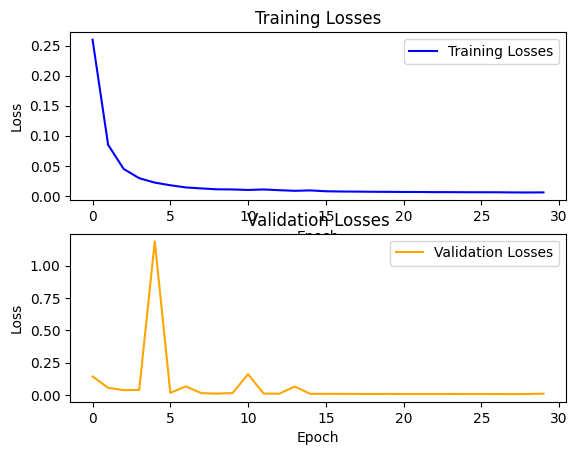

In [119]:
num_epochs = 30
model, train_losses, val_losses, iou_test = learning(num_epochs, train_loader, val_loader, model, optimizer, criterion)

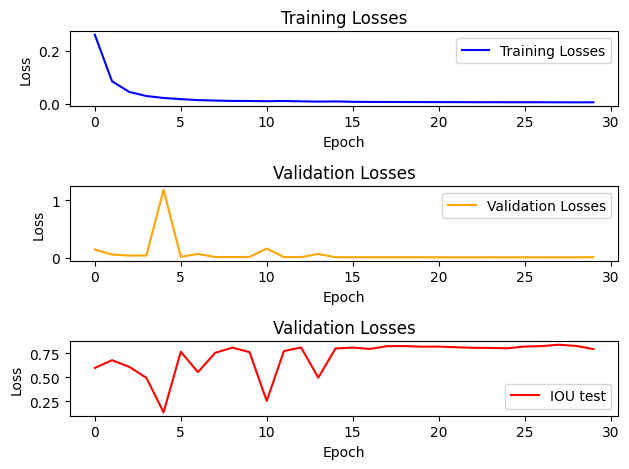

In [120]:
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(iou_test, label='IOU test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('IOU Losses')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation (оценка качества модели)

100%|██████████| 72/72 [00:42<00:00,  1.69it/s]


IOU: 0.8067970529465
AP: -0.03188255332452171


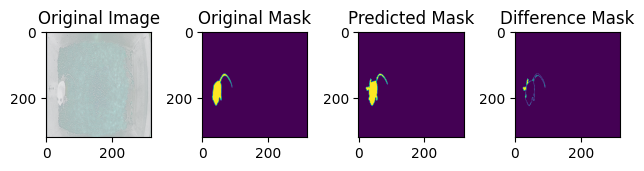

In [121]:
validation(model, train_loader, 1)

100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


IOU: 0.7934709446746874
AP: -0.03875678433838679


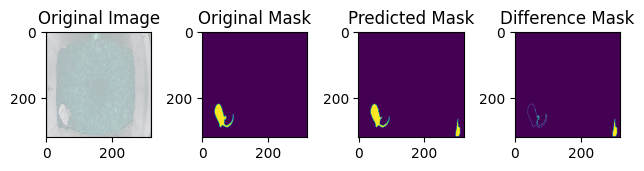

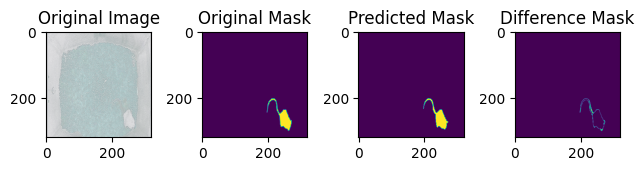

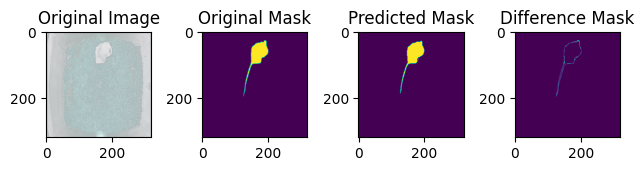

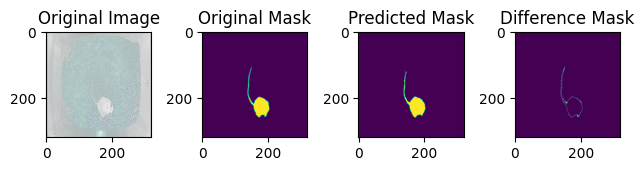

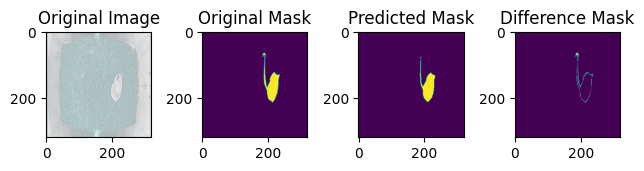

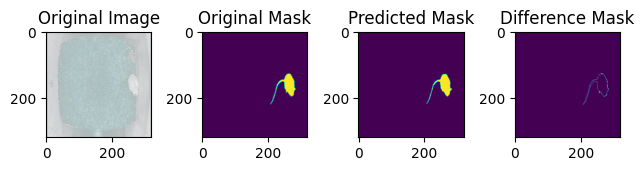

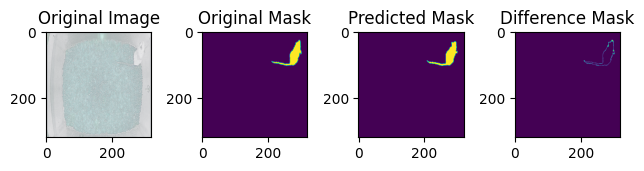

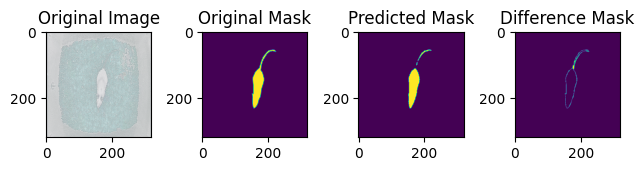

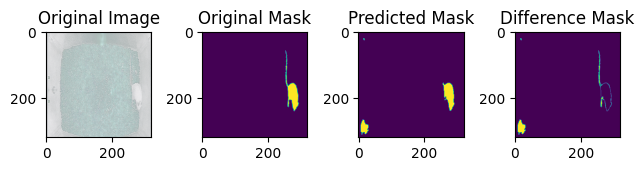

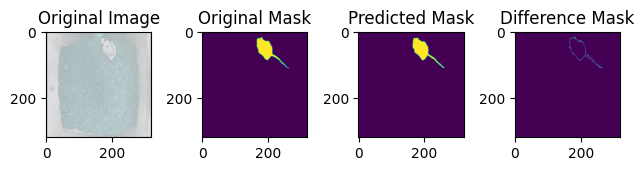

In [124]:
validation(model, val_loader, 10)

100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


IOU: 0.7951206036653122
AP: -0.04876793443650198


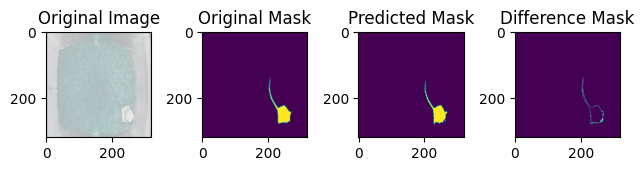

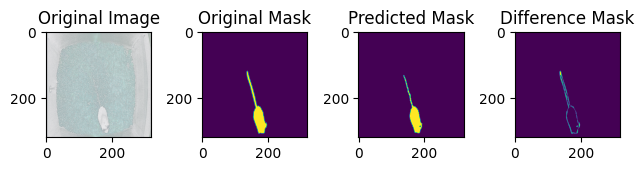

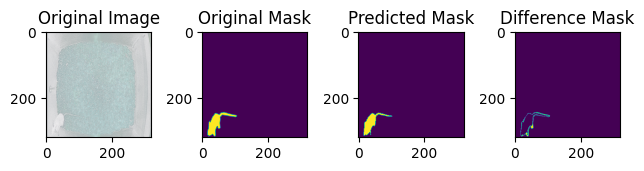

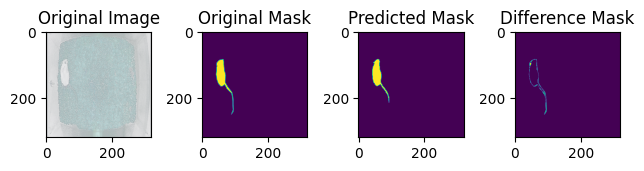

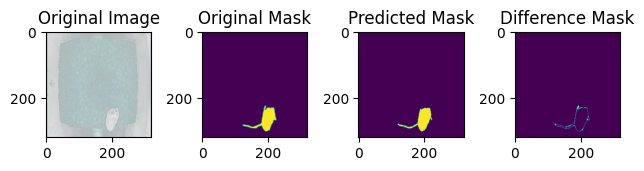

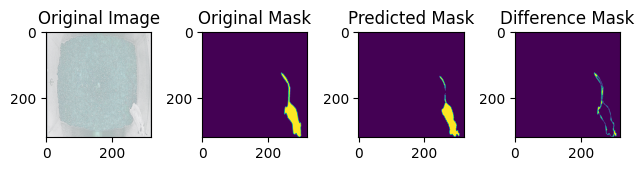

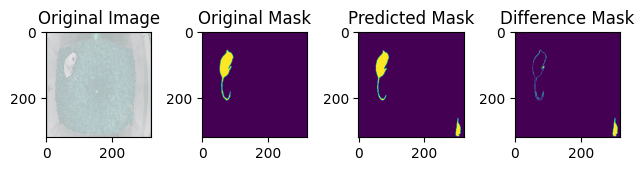

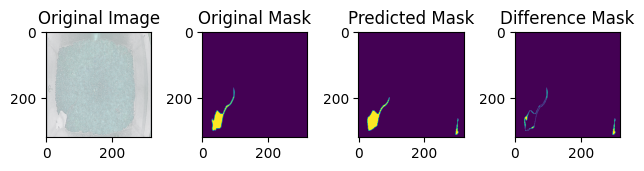

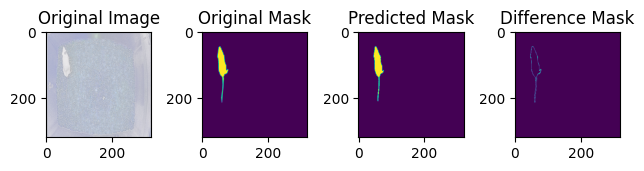

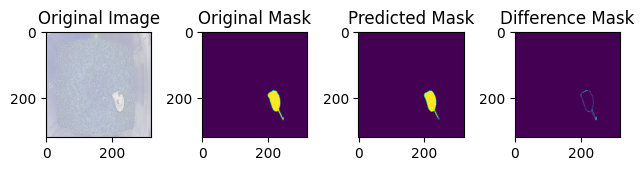

In [125]:
validation(model, test_loader, 10)

In [126]:
delete_generated_images(data_vertical, data_horizontal)